In [1]:
from google.colab import drive
drive.mount("/content/drive")
!mkdir /content/images
!cp -r /content/drive/MyDrive/IIT-Projects/third-umpire-decision-automation/backend/experiments/data/SAM/* /content/images

Mounted at /content/drive


In [9]:
!pip install -qq opencv-python matplotlib onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 44.8 MB/s eta 0:00:00


In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!pip install -qq opencv-python matplotlib onnxruntime onnx
!pip install -qq 'git+https://github.com/facebookresearch/segment-anything.git'

--2023-04-29 10:55:21--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.70, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   230MB/s    in 12s     

2023-04-29 10:55:33 (210 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

  Preparing metadata (setup.py) ... done


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## ONNX

In [11]:
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [12]:
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint)

In [13]:
import warnings

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [14]:
onnx_model_quantized_path = "sam_onnx_quantized_example.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]
Ignore Ma

In [23]:
!pip install -qq sagemaker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.0/748.0 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 17.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 k

In [26]:
!mkdir ~/.aws
!mv config ~/.aws/config
!mv credentials ~/.aws/credentials

In [27]:
from sagemaker.s3 import S3Uploader
S3Uploader.upload("/content/sam_onnx_quantized_example.onnx", "s3://third-umpire-decision-automation-osura/model-weights")

's3://third-umpire-decision-automation-osura/model-weights/sam_onnx_quantized_example.onnx'

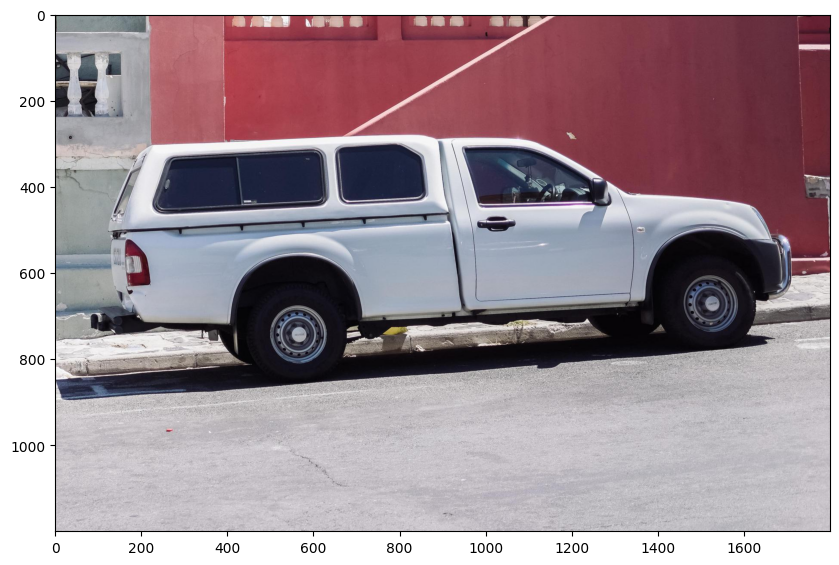

In [15]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [7]:
from segment_anything import sam_model_registry, SamPredictor
import onnxruntime
import numpy as np
import cv2

onnx_model_path = "/content/sam_onnx_quantized_example.onnx"
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint)

ort_session = onnxruntime.InferenceSession(onnx_model_path)
predictor = SamPredictor(sam)

def predict(image, input_box):
    predictor.set_image(image)
    image_embedding = predictor.get_image_embedding().numpy()

    onnx_box_coords = input_box.reshape(2, 2)
    onnx_box_labels = np.array([2,3])

    onnx_coord = np.concatenate([onnx_box_coords], axis=0)[None, :, :]
    onnx_label = np.concatenate([onnx_box_labels], axis=0)[None, :].astype(np.float32)

    onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

    onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
    onnx_has_mask_input = np.zeros(1, dtype=np.float32)

    ort_inputs = {
        "image_embeddings": image_embedding,
        "point_coords": onnx_coord,
        "point_labels": onnx_label,
        "mask_input": onnx_mask_input,
        "has_mask_input": onnx_has_mask_input,
        "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
    }

    masks, _, _ = ort_session.run(None, ort_inputs)
    masks = masks > predictor.model.mask_threshold

    return masks

image = cv2.imread('images/truck.jpg')
input_box = np.array([425, 600, 700, 875])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = predict(image, input_box)

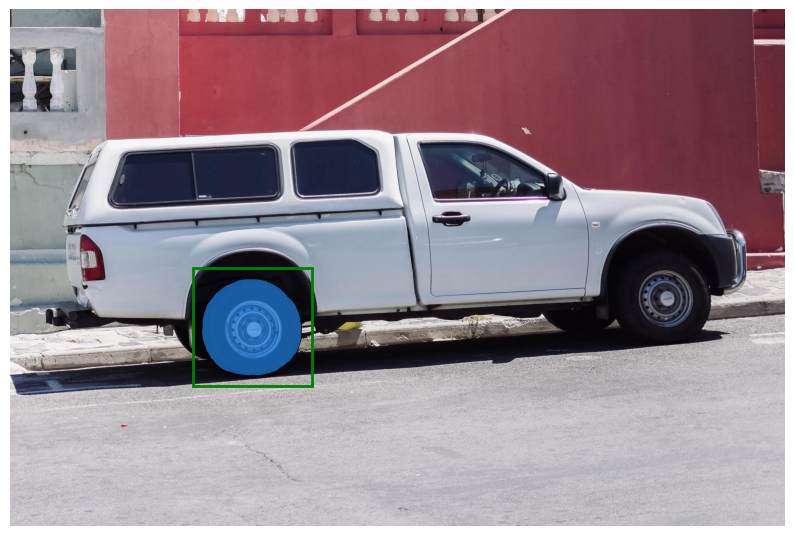

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
# show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Example image

In [32]:
image = cv2.imread('images/cricket-3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

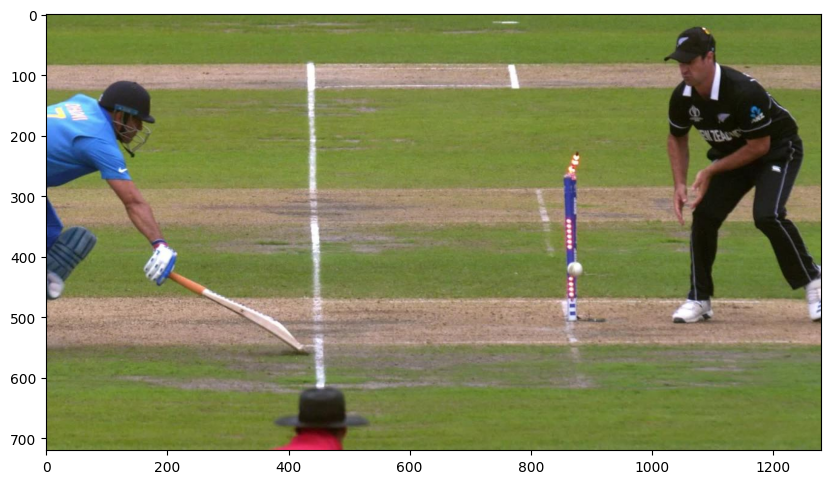

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [ ]:
from segment_anything import sam_model_registry, SamPredictor
    
sam_checkpoint = "model-weights/sam_vit_h_4b8939.pth"

model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device=device)



Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [ ]:
image1 = cv2.imread('images/cricket-1.png')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
predictor1 = SamPredictor(sam)
predictor1.set_image(image1)

image2 = cv2.imread('images/cricket-2.png')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
predictor2 = SamPredictor(sam)
predictor2.set_image(image2)

image3 = cv2.imread('images/cricket-3.jpg')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
predictor3 = SamPredictor(sam)
predictor3.set_image(image3)

In [ ]:
input_box1 = []
input_box2 = []
input_box3 = []

with open("images/cricket-1.txt") as handler:
    dec_cont = handler.read()
    dec_cont = list(map(lambda line: [float(val) for val in line.split(" ")], dec_cont.strip().split("\n")))
    bastman_box = np.array(list(filter(lambda line: line[0]==1.0, dec_cont))[0][1:])
    H, W, _ = image1.shape
    bastman_box[0::2] = bastman_box[0::2]*W
    bastman_box[1::2] = bastman_box[1::2]*H
    x,y,w,h = bastman_box
    input_box1 = np.array([x-w/2, y-h/2, x+w/2, y+h/2]).astype(np.int64)

with open("images/cricket-2.txt") as handler:
    dec_cont = handler.read()
    dec_cont = list(map(lambda line: [float(val) for val in line.split(" ")], dec_cont.strip().split("\n")))
    bastman_box = np.array(list(filter(lambda line: line[0]==1.0, dec_cont))[0][1:])
    H, W, _ = image2.shape
    bastman_box[0::2] = bastman_box[0::2]*W
    bastman_box[1::2] = bastman_box[1::2]*H
    x,y,w,h = bastman_box
    input_box2 = np.array([x-w/2, y-h/2, x+w/2, y+h/2]).astype(np.int64)

input_box3 = np.array([0,100,450,600]) # cricket-3

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

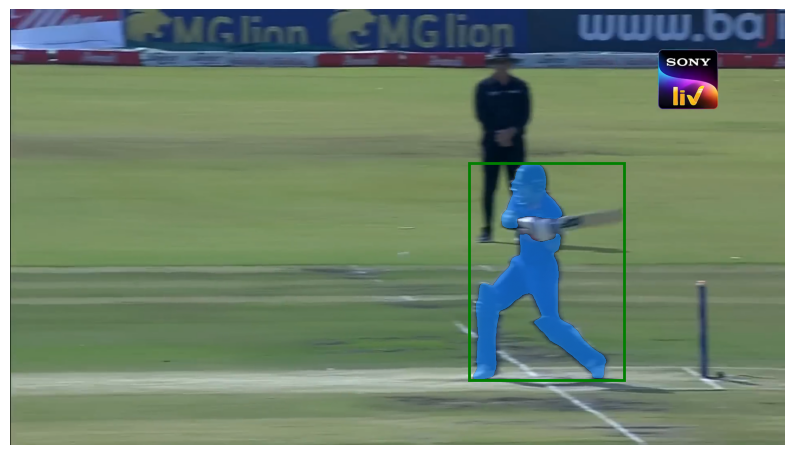

In [ ]:
masks, scores, logits = predictor1.predict(
    point_coords=None,
    point_labels=None,
    box=input_box1[None, :],
    multimask_output=False,
)
plt.figure(figsize=(10, 10))
plt.imshow(image1)
show_mask(masks[0], plt.gca())
show_box(input_box1, plt.gca())
plt.axis('off')
plt.show()

In [5]:
import cv2 as cv
from segment_anything import sam_model_registry, SamPredictor

class BatsmanSegmentor:
    def __init__(self, model_path, model_type="vit_h"):
        model_type = "vit_h"
        sam = sam_model_registry[model_type](checkpoint=model_path)
        predictor = SamPredictor(sam)

        self.predictor = predictor

    def __call__(self, img_path, bbox):
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        self.predictor.set_image(img)

        masks, scores, logits = self.predictor.predict(
            point_coords=None,
            point_labels=None,
            box=(bbox),
            multimask_output=False,
        )

        return masks[0]

    def predict(self, bbox):

        masks, scores, logits = self.predictor.predict(
            point_coords=None,
            point_labels=None,
            box=(bbox),
            multimask_output=False,
        )

        return masks[0]

segmentor = BatsmanSegmentor("model-weights/sam_vit_h_4b8939.pth")

In [24]:
import numpy as np
mask = segmentor("/content/images/cricket-3.jpg", np.array([0,100,450,600]))

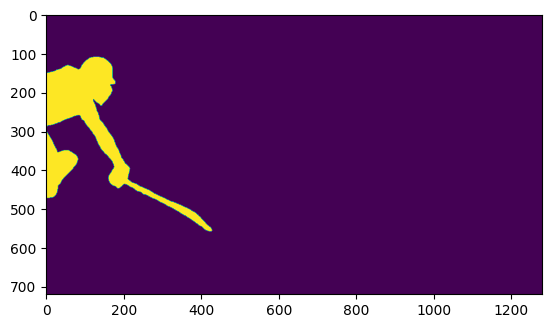

In [25]:
import matplotlib.pyplot as plt

plt.imshow(mask)
plt.show()

In [29]:
def getBoundariesFromMask(
    mask, normalize=True, epsilon: float = None, threshold_area=100
):
    """
    Typical epsilon value: 1.3
    """
    H, W = mask.shape
    
    contours_raw, hierarchy_raw = cv.findContours(
        mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE
    )

    # reduce the number of points
    if epsilon is not None:
        contours_reduced = []
        for i in range(len(contours_raw)):
            reduced_contour = cv.approxPolyDP(contours_raw[i], epsilon, closed=True)
            contours_reduced.append(reduced_contour)
    else:
        contours_reduced = contours_raw

    if len(contours_reduced) > 0:
        # filter the contours by area
        contours, hierarchy = [], []
        for cnt, hir in zip(contours_reduced, hierarchy_raw[0]):
            area = cv.contourArea(cnt)
            if area > threshold_area:
                contours.append(cnt)
                hierarchy.append(hir)
        hierarchy = np.array(hierarchy)

        if len(contours) > 0:
            no_parent = hierarchy[:, 3] == -1
            no_parent_ids = np.where(no_parent)[0]
            contours = [contours[i].squeeze() for i in no_parent_ids]

            boundaries = []
            for cnt in contours:
                X, Y = cnt[:, 0], cnt[:, 1]

                if normalize:
                    X = X / W
                    Y = Y / H
                bnd = np.zeros(cnt.shape[0] * 2)
                bnd[0::2] = X
                bnd[1::2] = Y
                boundaries.append(bnd.tolist())

            return boundaries

    return []

boundaries = getBoundariesFromMask(mask.astype(np.uint8), True)

In [32]:
len(boundaries)
boundaries_extended = [[0, *bnd] for bnd in boundaries]
saveAnnotationsFile( boundaries_extended, "seg.txt")

In [31]:
from typing import Tuple, Union

def saveAnnotationsFile(
    cntnt: Union[str, Tuple[Tuple]], file_path: str, round_deci=None
) -> None:
    if type(cntnt) != str:
        cntnt = cvtAnnotationsLST2TXT(cntnt, round_deci)
    with open(file_path, "w") as handler:
        handler.write(cntnt)

def cvtAnnotationsLST2TXT(lst_cntnt, round_deci=None):
    if round_deci is not None:
        strn = "\n".join(
            list(
                map(
                    lambda box: " ".join(
                        [
                            str(int(box[0])),
                            *list(
                                map(
                                    lambda num: str(np.round(num, round_deci)).ljust(
                                        8, "0"
                                    ),
                                    box[1:],
                                )
                            ),
                        ]
                    ),
                    lst_cntnt,
                )
            )
        )
    else:
        strn = "\n".join(
            list(
                map(
                    lambda box: " ".join([str(int(box[0])), *list(map(str, box[1:]))]),
                    lst_cntnt,
                )
            )
        )
    return strn
